In [1]:
import pandas as pd

# read 5guys_flight_data_preprocessed.csv into a dataframe
df = pd.read_csv('data/5guys_flight_data_preprocessed.csv')

# Train

C:\Users\jcmuf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jcmuf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jcmuf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

Scores for each fold: [0.49810117 0.49795651 0.49596351 0.49745123 0.49775574]
Mean f1 score: 0.497


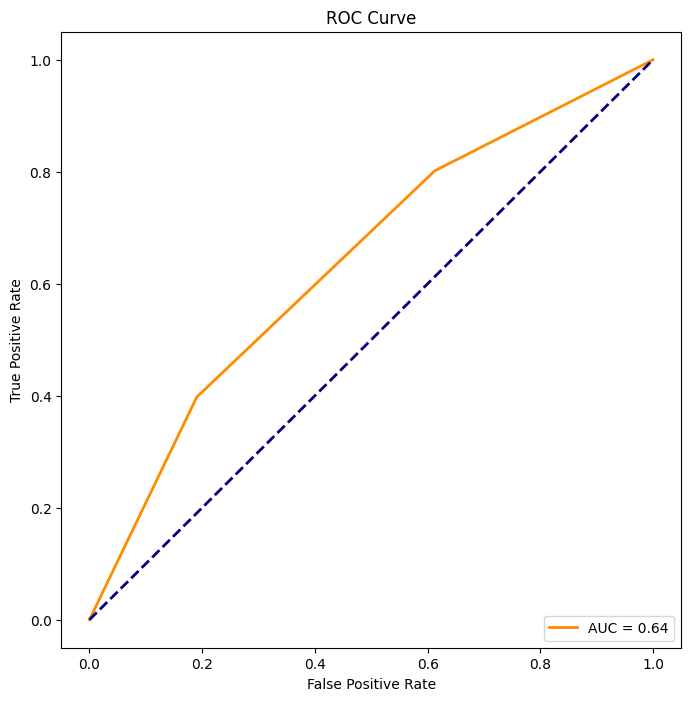

Accuracy: 0.7317723535315404
Confusion Matrix:
[[356580  83831]
 [ 61826  40798]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83    440411
         1.0       0.33      0.40      0.36    102624

    accuracy                           0.73    543035
   macro avg       0.59      0.60      0.59    543035
weighted avg       0.75      0.73      0.74    543035



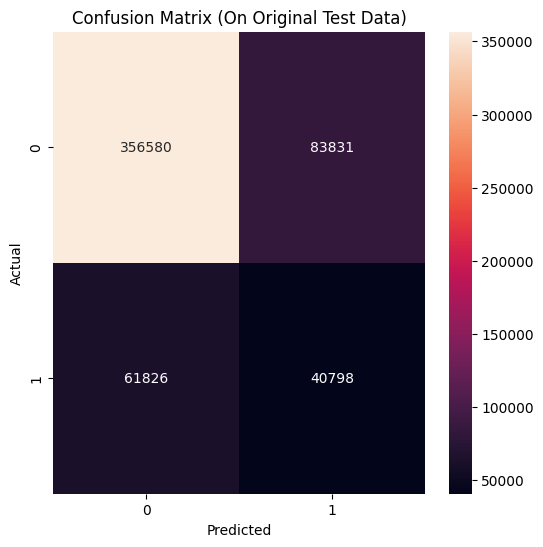

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# target feature
target = 'DEP_DEL15'

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data but without standardizing the categorical features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)
# Standardize the data but without standardizing the categorical features
scaler = StandardScaler()
X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

# Scale only the numerical features
numerical_features = ['Age']  # Replace 'Age' with the actual numerical feature names
X_train_scaled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# use GridSearchCV to find the best hyperparameters for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

# Create the KNN classifier
model = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

# Train the KNN classifier with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_scaled, y_train_resampled)

# Predict on the test data using the best classifier
y_pred_best = best_knn.predict(X_test_scaled)
y_pred_proba_best = best_knn.predict_proba(X_test_scaled)[:, 1]

# Perform cross-validation for scores
# scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=cv, scoring='f1')

# Print the mean of the cross validation scores
print(f'Scores for each fold: {scores}')
print(f'Mean f1 score: {scores.mean():.3f}')

# Train classifier
model.fit(X_train_scaled, y_train_resampled)

# Predict on test data
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display metrics
# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, cmap='rocket', fmt='g', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()